# CFL Condition
The convergence condition by Courant–Friedrichs–Lewy (CFL) is a necessary condition for convergence while solving certain partial differential equations (usually hyperbolic PDEs) numerically. 

For upwind scheme, the CFL condition requires:
    
$$CFL = \frac{\Delta r \Omega_{rot}}{|v_{r}|\Delta \phi} \leq 1$$
    
    
In order to verify the HUX model is not sensitive to the CFL number. I repeated the mappings using between 100 and 10000 points in radial mesh grid spacing, while checking if the CFL condition is violated (see algorithm 1). 


# HUX-f Pseudocode 

![](figures/HUX_F_pc.png)

 
# Step 1: visualize the data in vr002.hdf. 
### Here, we use the global Heliospheric MHD solutions as the 'ground truth'. 

In [49]:
import matplotlib as mpl
import numpy as np 
from tools.psihdf4 import rdhdf_3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import numpy,math
import scipy.optimize as optimization
from scipy.optimize import leastsq
import pickle
from scipy.interpolate import RegularGridInterpolator
import scipy

%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 5] # default fig size.

In [50]:
# read the 3d hdf file. 
hdf_file_path = "data/vr002.hdf"
r, t, p, f = rdhdf_3d(hdf_file_path)

In [51]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

In [52]:
# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [53]:
# change scalers units: 
# Theta: from radians to degrees. colatitude. 
t[0] = 0
t[-1] = np.pi
t_plot = np.pi/2 - t
t_plot = np.sin(t_plot)

In [54]:
# Phi: from radians to degrees. longitude.
p = (180/np.pi)*p

In [55]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r = (695700)*r

![](figures/mas_conversion.png)

In [56]:
# Velocity profile: PSI convertion units conversion from MAS to MKS (table in figures/mas_conversion.png)
f = (481.3711)*f

In [57]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)

Velocity matrix shape:  (129, 111, 140)
Phi dim:  129
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [58]:
# slice velocity_mat, for r first index (30 solar radii).
v_initial = f[:, :, 0]
print("shape of v_iniital", np.shape(f))
# slice velocity_mat, for r last index(approx 1 AU).
v_final = f[:, :, -1]
print("shape of v_final", np.shape(f))

shape of v_iniital (129, 111, 140)
shape of v_final (129, 111, 140)


In [59]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p[0]], 0.5 * (p[1:] + p[:-1]), [p[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

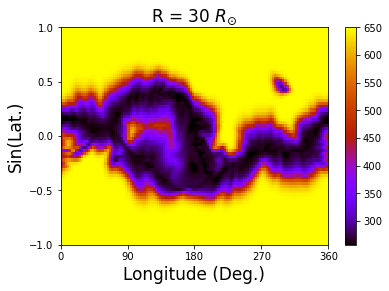

In [60]:
%matplotlib inline
fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, v_initial.T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

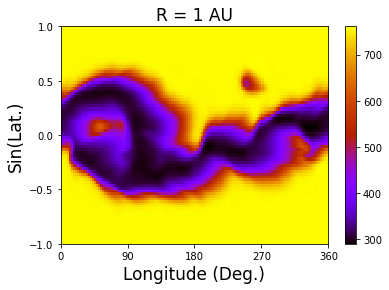

In [61]:
fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=17)
ax.set_ylabel("Sin(Lat.)", fontsize=17)
ax.set_xlabel("Longitude (Deg.)", fontsize=17)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, v_final.T, cmap=cmap)
_ = fig.colorbar(im, ax=ax)

# Step 2: Apply the HUX (Heliospheric Upwind Extrapolation) Model.


Inviscid Burgers' equation:

$$-\Omega_{rot} \frac{\partial v_{r}}{\partial \phi} + v_{r} \frac{\partial v_{r}}{\partial r} = 0$$

Then, by the upwind difference algorithm, we get:

$$ v_{i+1, j} = v_{i, j} - \Delta r ( a^{+} \Delta^{-} + a^{-}\Delta^{+}) $$

The indicies i and j refer to the r and $\phi$ grids, respectively. 

Where:

$$ a^{+} = \max(-\frac{\Omega_{rot}}{v_{i,j}}, 0)$$

$$ a^{-} = \min(-\frac{\Omega_{rot}}{v_{i,j}}, 0)$$

$$ \Delta^{-} = \frac{v_{i,j} - v_{i,j-1}}{\Delta \phi}$$

$$ \Delta^{+} = \frac{v_{i,j+1} - v_{i,j}}{\Delta \phi}$$


Since $\frac{-\Omega_{rot}}{v_{i,j}}$ is always less than zero for the solar wind, then $a^{+} = 0$. 
Meaning:

$$ v_{i+1, j} = v_{i, j} + \frac{\Delta r \Omega_{rot}}{v_{i,j}} (\frac{v_{i, j+1} - v_{i,j}}{\Delta \phi}) $$

parameters:

$$ \Omega_{rot} = \frac{2\pi}{25.38} \frac{1}{days} = \frac{2\pi}{25.38\cdot 86400} \frac{1}{sec} $$

Effect of Acceleration:

Below is a simple expression to mimic residual accelartion from 30 Solar Radii to 1 AU:

$$ v_{acc} (r) = \alpha v_{ro} (1-{e}^{\frac{-r}{r_{h}}}) $$



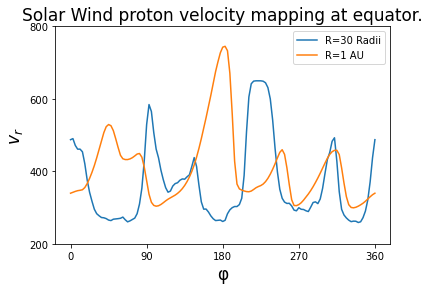

In [62]:
# plot the equator slice theta=90. 
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
fig, ax = plt.subplots()
_ = ax.plot(p, solar_equator_r_30_radii, label="R=30 Radii")
_ = ax.plot(p, solar_equator_r_1_au, label="R=1 AU")
_ = ax.set_xlabel("\u03C6", fontsize=17)
_ = ax.set_ylabel('$v_{r}$', fontsize=17)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Solar Wind proton velocity mapping at equator.", fontsize=17)
_ = plt.legend()

In [63]:
# setting parameters. 
omega_rot = (2*np.pi)/(25.38*86400)
alpha = 0.15
rh = 50* (695700)

In [64]:
# change phi to be in radian units. 
p = (np.pi/180)*p 

In [65]:
# setting parameters. The phi and radial mesh spacing. 
dp_vec = p[1:] - p[:-1]
dr_vec = r[1:] - r[:-1]

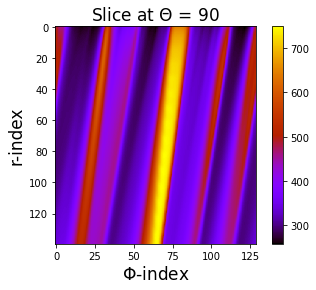

In [66]:
# initial slice
fig4, ax4 = plt.subplots()
_ = im = ax4.imshow(f[:, 55, :].T, cmap=cmap)
_ = fig4.colorbar(im, ax=ax4)
_ = ax4.set_title("Slice at $\Theta$ = 90", fontsize=17)
_ = ax4.set_xlabel("$\Phi$-index", fontsize=17)
_ = ax4.set_ylabel("r-index", fontsize=17)

In [109]:
def apply_upwind_model(r_initial, r, p, omega_rot, dr_vec, dp_vec, alpha, rh, add_v_acc=True):
    """ Apply 1d upwind model to the inviscid burgers equation. r/phi grid."""
    
    v = np.zeros((len(r), len(p))) # initialize array vr.
    v[0, :] = r_initial

    if add_v_acc:
        v_acc = alpha * (v[0, :]*(1 - np.exp(-r[0]/rh)))
        v[0, :] = v_acc + v[0, :]

    for i in range(len(r) -1):
        for j in range(len(p)):
            if j == len(p) -1: # force periodicity 
                v[i+1, j] = v[i+1, 0]

            else:
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v[i,j]) > 1:
                    print(dr_vec[i] - dp_vec[j]*v[i,j]/omega_rot) 
                    print(i, j) # courant condition
                    print("Courant condition exceeded")

                frac1 = (v[i, j + 1] - v[i, j]) / v[i, j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v[i + 1, j] = v[i, j] + frac1*frac2
    
            
    return v

# Interpolate vr_002.hdf to a new grid in r.

In [166]:
r_min = 32
new_r_min  = np.linspace(r[0], r[-1], r_min)
new_r_50   = np.linspace(r[0], r[-1], 50)
new_r_100  = np.linspace(r[0], r[-1], 100)
new_r_1000 = np.linspace(r[0], r[-1], 1000)

In [167]:
# create a 3d mesh grid.
pp, tt, rr = numpy.meshgrid(p, t, new_r_min, indexing='ij')
coordinate_grid_min = numpy.array([pp.T, tt.T, rr.T]).T

pp, tt, rr = numpy.meshgrid(p, t, new_r_50, indexing='ij')
coordinate_grid_50 = numpy.array([pp.T, tt.T, rr.T]).T

pp, tt, rr = numpy.meshgrid(p, t, new_r_100, indexing='ij')
coordinate_grid_100 = numpy.array([pp.T, tt.T, rr.T]).T

pp, tt, rr = numpy.meshgrid(p, t, new_r_1000, indexing='ij')
coordinate_grid_1000 = numpy.array([pp.T, tt.T, rr.T]).T

In [168]:
# linear interpolation
interp_function = RegularGridInterpolator(points=(p, t ,r), values=f, bounds_error=False, fill_value=None)

In [169]:
f_min_newgrid = interp_function(coordinate_grid_min)

In [170]:
f_50_newgrid = interp_function(coordinate_grid_50)

In [171]:
f_100_newgrid = interp_function(coordinate_grid_100)

In [172]:
f_1000_newgrid = interp_function(coordinate_grid_1000)

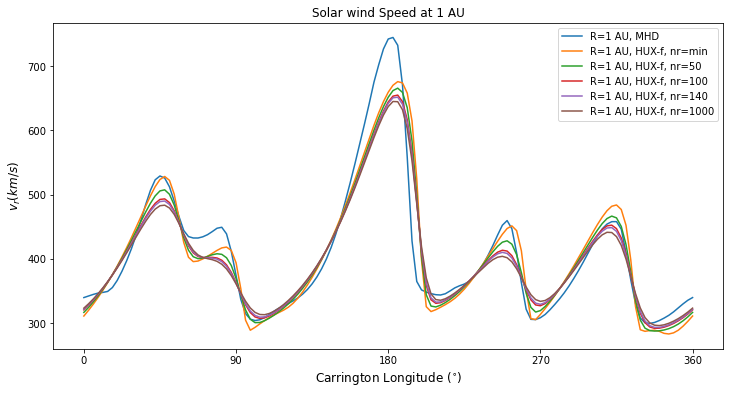

In [175]:
%matplotlib inline
fs1 = 12
p_deg = p*180/np.pi
fig, ax = plt.subplots(figsize = (12,6))
_ = ax.plot(p_deg, solar_equator_r_1_au, label="R=1 AU, MHD")
_ = ax.plot(p_deg, apply_upwind_model(f_min_newgrid[:, 55, 0], new_r_min, p, omega_rot, new_r_min[1:]-new_r_min[:-1], dp_vec, 0.15, rh)[-1, :], label="R=1 AU, HUX-f, nr=min")
_ = ax.plot(p_deg, apply_upwind_model(f_50_newgrid[:, 55, 0], new_r_50, p, omega_rot, new_r_50[1:]-new_r_50[:-1], dp_vec, 0.15, rh)[-1, :], label="R=1 AU, HUX-f, nr=50")
_ = ax.plot(p_deg, apply_upwind_model(f_100_newgrid[:, 55, 0], new_r_100, p, omega_rot, new_r_100[1:]-new_r_100[:-1], dp_vec, 0.15, rh)[-1, :], label="R=1 AU, HUX-f, nr=100")
_ = ax.plot(p_deg, apply_upwind_model(solar_equator_r_30_radii, r, p, omega_rot, dr_vec, dp_vec, 0.15, rh)[-1, :], label="R=1 AU, HUX-f, nr=140")
_ = ax.plot(p_deg, apply_upwind_model(f_1000_newgrid[:, 55, 0], new_r_1000, p, omega_rot, new_r_1000[1:]-new_r_1000[:-1], dp_vec, 0.15, rh)[-1, :], label="R=1 AU, HUX-f, nr=1000")

_ = ax.set_xlabel("Carrington Longitude ($^{\circ}$)", fontsize=fs1)
_ = ax.set_ylabel('$v_{r} (km/s)$', fontsize=fs1)
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])

_ = ax.set_title("Solar wind Speed at 1 AU", fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/CFL_comp.png')